In [1]:
import os
import pandas as pd
import ipywidgets as widgets
from IPython.core.display import display, HTML
from IPython.display import display, IFrame, Image

display(HTML('<link rel="stylesheet" href="style_browser.css">'))

from ucsfneuroviz.importer import import_dataframe
from ucsfneuroviz.interactive_behav_plots import interactive_individual_line_plot
from ucsfneuroviz.interactive_struct_plots import interactive_brain_zscore_plot, validate_id_number
from ucsfneuroviz.interactive_diffusion_plots import interactive_dti_metrics

from ucsfneuroviz.fc_vars import FC_vars, FC_vars_select

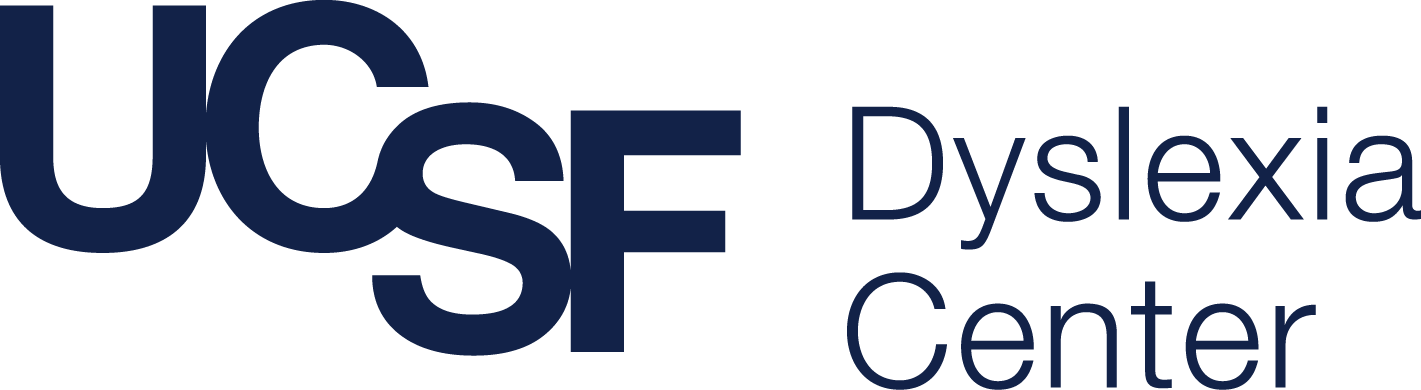

In [3]:
# Insert photo from ./data/ folder
Image(filename='./data/UCSF_sublogo_DyslexiaCenter_navy_RGB.png', width=250)

In [ ]:
# Import Data
brain_df = pd.read_csv('/Volumes/language/language/math_cognition/ucsfneuroviz/structural/all_structural_data.csv', index_col=0)
behavior_df = import_dataframe('/Volumes/language/language/math_cognition/ucsfneuroviz/behavior/redcap_labels_with_diagnoses.csv')
# Convert 'Rey-O Delay Percentile' "<1" to 0.5 and Force to numeric
behavior_df['Rey-O Delay Percentile:'] = behavior_df['Rey-O Delay Percentile:'].apply(lambda x: 0.5 if x =="<1" else x)
behavior_df['Rey-O Delay Percentile:'] = pd.to_numeric(behavior_df['Rey-O Delay Percentile:'])
# Replace all instances of "Unchecked" with 0 and "Checked" with 1
# behavior_df = behavior_df.replace(to_replace="Unchecked", value=0)
# behavior_df = behavior_df.replace(to_replace="Checked", value=1)

In [ ]:
import ipywidgets as widgets
from IPython.display import display

# Initialize text input widgets for subject ID and date
subject_id_input = widgets.Text(
    value='',
    placeholder='Enter Subject ID',
    description='Subject ID:',
    disabled=False
)

date_input = widgets.Text(
    value='',
    placeholder='Enter Date',
    description='Date:',
    disabled=False
)

submit_button = widgets.Button(
    description='Submit',
    disabled=False,
    button_style='',
    tooltip='Click to generate plots',
    icon='check'
)

# Function to generate all outputs
def generate_all_outputs(button):
    for i in range(len(tab.children)):
        generate_outputs(i)

# Attach click event to the submit button
submit_button.on_click(generate_all_outputs)

# Display the text input widgets and the submit button
input_widgets = widgets.HBox([subject_id_input, date_input, submit_button])
display(input_widgets)

# Initialize output widgets for each tab
structural_output = widgets.Output()
diffusion_output = widgets.Output()
functional_output = widgets.Output()
behavior_output = widgets.Output()
out_error = widgets.Output()

display(out_error)

# Initialize the tab widget and set the titles
tab = widgets.Tab()
tab.children = [structural_output, diffusion_output, functional_output, behavior_output]
tab.set_title(0, 'Structural MRI')
tab.set_title(1, 'Diffusion MRI')
tab.set_title(2, 'Functional MRI')
tab.set_title(3, 'Behavioral Scores')

diagnosis_columns = ['Diagnosis Overall', 'Dyslexia and ADHD', 'Dyslexia Phenotype', 'Dyslexia Phenotype Short', 'Dyslexia and Dyscalculia', 'Dyslexia and MLD', 'MLD Subtype Primary', 'MLD Subtype Secondary']

# Define your function to generate outputs based on the selected tab
def generate_outputs(tab_index):
    # Fetch subject ID and date from the global text input widgets
    # subject_id = subject_id_input.value.strip()
    subject_id = validate_id_number(subject_id_input.value.strip(), behavior_df, out_error)
    date = date_input.value.strip()

    if not subject_id or not date:
        print("Please enter both Subject ID and Date.")
        return

    if tab_index == 0:  # Structural MRI
        with structural_output:
            structural_output.clear_output(wait=True)
            interactive_brain_zscore_plot(brain_df, behavior_df, diagnosis_columns, subject_id, date)

    elif tab_index == 1:  # Diffusion MRI
        with diffusion_output:
            diffusion_output.clear_output(wait=True)

            local_path = "./data/"
            ldrive_path = f"/Volumes/language/language/mkersey/qsiprep_related/testing_recon_options/mrtrix_pyafq_tractometry_reco/"
            folder_path = f"sub-{subject_id}/ses-{date}/dwi/sub-{subject_id}_ses-{date}_space-T1w_desc-preproc/" # copy file from ldrive to local folder
            file_name = f"sub-{subject_id}_ses-{date}_space-T1w_desc-preproc_dwi_space-RASMM_model-probCSD_algo-AFQ_desc-viz_dwi.html"
            full_path_to_file = os.path.join(ldrive_path, folder_path, file_name)

            # if file is not already in local folder, copy it from ldrive
            if not os.path.isfile(os.path.join(local_path, file_name)):
                os.system(f"cp {full_path_to_file} {local_path}")

            full_path_local = os.path.join(local_path, file_name)

            iframe = IFrame(src=full_path_local, width="100%", height="600")
            display(iframe)

            interactive_dti_metrics(proc_output_dir=ldrive_path, sub_id=subject_id, ses_id=date)
    
    elif tab_index == 2:  # Functional MRI
        with functional_output:
            functional_output.clear_output(wait=True)
            iframe = IFrame(src='', width="1000", height="600")
            display(iframe)

    elif tab_index == 3:  # Behavioral Scores
        with behavior_output:
            behavior_output.clear_output(wait=True)
            interactive_individual_line_plot(behavior_df, 'ID Number', diagnosis_columns, FC_vars_select, subject_id, date)

# Function to run when the selected tab changes
def on_tab_value_change(change):
    generate_outputs(change['new'])  # Manually trigger the function

# Attach the change event to the tab
tab.observe(on_tab_value_change, names='selected_index')

# Generate default outputs (for the first tab)
# generate_outputs(0)

# Display the tab
display(tab)



In [ ]:
# diagnosis_columns = ['Diagnosis Overall', 'Dyslexia and ADHD', 'Dyslexia Phenotype', 'Dyslexia Phenotype Short', 'Dyslexia and Dyscalculia', 'Dyslexia and MLD', 'MLD Subtype Primary', 'MLD Subtype Secondary']
# interactive_brain_zscore_plot(brain_df, behavior_df, diagnosis_columns)

In [ ]:
# interactive_individual_line_plot(behavior_df, 'ID Number', diagnosis_columns, FC_vars_select)